# Predicting playlist membership

In [1]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle

import warnings
warnings.filterwarnings("ignore")

## Preprocessing

The first step is accessing the playlist data using an API and proccessing it into a format to be used in a model

In [4]:
USER_1_OAUTH = "BQBiB99bzXmez8SBmcWuzV5QBFyHtM2glPfXe2FqMUcuIMKOGM1ksE8ddIyhxaClhDjcBQR-v7hWhaDM56lVrGyiQNYQWCEIK5lhkjRm32i9Y4eT_Ly8K46C_cfqsHU2JsgIqydrFEG6XhkK2r1UZa-xNx976drd4yd3sGYAaRY8zmD8HkusvLWvkQ" 
USER_2_OAUTH = "BQBwId1cV3KS19xfQwxAGFdmzU-kOw5T75Ox75ShBw4JR1eymVv_YfdynyUbnk_2X53sKr0dCsu7OuEfqcw4TLGYDn-zcXZOQFK8j434LkqivzGtFdq-uyJ5CUbVPX7zzIf3J7Hjv7ujGlWQZPSR"

def get_liked_songs_for_user(oauth_token):
    all_liked_songs = []
    
    headers = {
        "Accept": "application/json",
        "Content-Type": "application/json",
        "Authorization": f"Bearer {oauth_token}",
    }
    url = "https://api.spotify.com/v1/me/tracks?limit=50"
    
    res = requests.get(url, headers=headers)
    res.raise_for_status()

    all_liked_songs.extend([track["track"]["id"] for track in res.json()["items"]])
    
    while res.json()["next"]:
        res = requests.get(res.json()["next"], headers=headers)
        res.raise_for_status()

        all_liked_songs.extend([track["track"]["id"] for track in res.json()["items"]])

    return all_liked_songs

user_1_tracks = get_liked_songs_for_user(USER_1_OAUTH)
user_2_tracks = get_liked_songs_for_user(USER_2_OAUTH)


In [5]:
print(len(user_1_tracks))
print(len(user_2_tracks))

366
819


In [6]:
user_1_tracks[:5]

['7CC6UbCs4iGsePSzFxYxNn',
 '123UKU5C3VGi3vrJTwtjQ1',
 '1XU6JOnyH8fSW0vzofEMCb',
 '7CFfqRW50ffULvBv7lfIIg',
 '3HDjPxAseM70WcLhv3PcMF']

In [7]:
user_2_tracks = user_2_tracks[:len(user_1_tracks)]

In [8]:
len(user_2_tracks)

366

In [9]:
def batcher(ids, batch):
    for i in range(0, len(ids), batch): 
        yield ids[i:i + batch]

def get_song_features(id_list, oauth_token):
    headers = {
        'Authorization': f"Bearer {oauth_token}",
        'Content-Type': 'application/json',
    }
    
    song_features_dict = {
        "track_id": [],
        "danceability": [],
        "energy": [],
        "key": [],
        "loudness": [],
        "mode_": [],
        "speechiness": [],
        "acousticness": [],
        "instrumentalness": [],
        "liveness": [],
        "tempo": [],
        "duration_ms": [],
        "time_signature": [],
    }   
    
    for ids in batcher(id_list, 100):
        these_ids = ",".join(ids)

        features_response = requests.get(f'https://api.spotify.com/v1/audio-features?ids={these_ids}', headers=headers)
        features_response.raise_for_status()

        for track in features_response.json()["audio_features"]:
            song_features_dict["track_id"].append(track["id"])
            song_features_dict["danceability"].append(track["danceability"])
            song_features_dict["energy"].append(track["energy"])
            song_features_dict["key"].append(track["key"])
            song_features_dict["loudness"].append(track["loudness"])
            song_features_dict["mode_"].append(track["mode"])
            song_features_dict["speechiness"].append(track["speechiness"])
            song_features_dict["acousticness"].append(track["acousticness"])
            song_features_dict["instrumentalness"].append(track["instrumentalness"])
            song_features_dict["liveness"].append(track["liveness"])
            song_features_dict["tempo"].append(track["tempo"])
            song_features_dict["duration_ms"].append(track["duration_ms"])
            song_features_dict["time_signature"].append(track["time_signature"])

    return(song_features_dict)
        

In [10]:
first_features = get_song_features(user_1_tracks, USER_1_OAUTH)

In [11]:
second_features = get_song_features(user_2_tracks, USER_2_OAUTH)

In [12]:
playlist_1_df = pd.DataFrame(first_features)
playlist_1_df['playlist'] = 0
playlist_1_df.head()

,track_id,danceability,energy,key,loudness,mode_,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,time_signature,playlist
0,7CC6UbCs4iGsePSzFxYxNn,0.319,0.236,5,-9.644,1,0.0318,0.8980,0.000016,0.2720,162.351,156091,4,0
1,123UKU5C3VGi3vrJTwtjQ1,0.806,0.398,2,-8.211,1,0.3540,0.7450,0.000000,0.0906,95.146,141932,4,0
2,1XU6JOnyH8fSW0vzofEMCb,0.637,0.519,6,-9.461,1,0.0283,0.3430,0.000057,0.2730,145.024,268147,4,0
3,7CFfqRW50ffULvBv7lfIIg,0.797,0.755,2,-5.393,1,0.0293,0.3310,0.000002,0.1240,129.955,135878,4,0
4,3HDjPxAseM70WcLhv3PcMF,0.619,0.481,10,-7.850,0,0.0366,0.0131,0.000100,0.1010,133.977,238067,4,0


In [13]:
playlist_2_df = pd.DataFrame(second_features)
playlist_2_df['playlist'] = 1
playlist_2_df.head()

,track_id,danceability,energy,key,loudness,mode_,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,time_signature,playlist
0,2QsquiKBcjvDUlO6QyvMEs,0.365,0.875,1,-3.228,1,0.1310,0.00893,0.000000,0.0786,98.708,225307,4,1
1,5yZtHXjySe6jDjOM6Yi3Mw,0.499,0.769,1,-5.576,1,0.0522,0.00416,0.027400,0.1170,110.835,224147,3,1
2,1yaISGEoawvX2l6cU7M13n,0.780,0.887,2,-3.352,1,0.0578,0.00064,0.718000,0.2720,123.000,154146,4,1
3,6EZXO2zjC6KlLbNwc2HDMc,0.507,0.239,9,-15.099,0,0.0352,0.76600,0.000793,0.1210,77.873,225307,4,1
4,6OkDQI3XFhWc4Ui18hi66h,0.533,0.129,3,-12.095,1,0.0441,0.93600,0.055200,0.0908,100.863,903453,4,1


In [14]:
all_tracks = playlist_1_df.append(playlist_2_df, ignore_index=True)
all_tracks.sample(5)

,track_id,danceability,energy,key,loudness,mode_,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,time_signature,playlist
136,2TMo5VM652clhr0KQ29dbj,0.651,0.944,2,-5.480,1,0.0381,0.0855,0.145000,0.1160,119.983,263440,4,0
341,5WU6T7jctoCeoSqEyaSR6B,0.637,0.782,9,-6.466,0,0.0294,0.0517,0.054900,0.1220,129.999,340853,4,0
653,39abghk7c6S1Pq8XMC0ORF,0.520,0.803,0,-11.535,1,0.0579,0.0934,0.047900,0.9760,106.962,277947,4,1
282,4vWNhCGqrNVfZxunY47GDf,0.544,0.758,0,-5.854,1,0.0319,0.0928,0.000232,0.1130,141.804,215933,4,0
236,0UhIdavKe4EQSJCTPd6wQa,0.654,0.786,0,-4.697,1,0.0879,0.1320,0.000000,0.0756,120.097,163427,4,0


In [47]:
track_features = all_tracks.drop(['track_id'], axis=1)
track_features.to_csv("all_data.csv", index=False)
track_features.sample(5)

,danceability,energy,key,loudness,mode_,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,time_signature,playlist
402,0.933,0.528,5,-6.472,0,0.1620,0.11200,0.329000,0.1630,109.975,214653,4,1
555,0.499,0.819,10,-6.781,1,0.0347,0.00577,0.008860,0.3680,125.976,337453,4,1
692,0.457,0.219,8,-15.325,0,0.0385,0.54500,0.000980,0.0681,168.550,323067,5,1
120,0.604,0.852,5,-7.159,0,0.1060,0.01350,0.000102,0.4410,161.958,198129,4,0
247,0.562,0.191,5,-17.438,1,0.0431,0.24100,0.018400,0.1200,116.111,256587,4,0


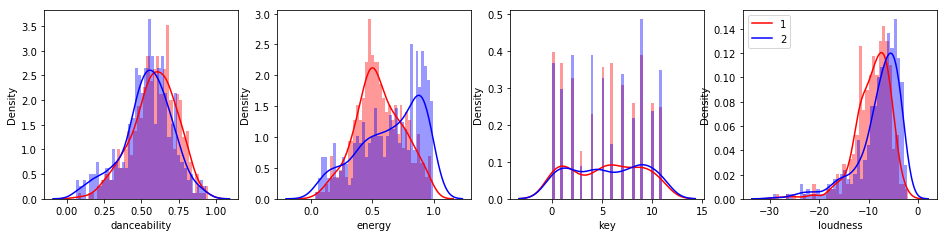

In [16]:
plt.figure(figsize=(16,16))
plt.subplot(4,4,1)
sns.distplot(track_features[track_features['playlist']==0]['danceability'], color='red', bins=40)
sns.distplot(track_features[track_features['playlist']==1]['danceability'], color='blue', bins=40)
plt.subplot(4,4,2)
sns.distplot(track_features[track_features['playlist']==0]['energy'], color='red', bins=40)
sns.distplot(track_features[track_features['playlist']==1]['energy'], color='blue', bins=40)
plt.subplot(4,4,3)
sns.distplot(track_features[track_features['playlist']==0]['key'], color='red', bins=40)
sns.distplot(track_features[track_features['playlist']==1]['key'], color='blue', bins=40)
plt.subplot(4,4,4)
sns.distplot(track_features[track_features['playlist']==0]['loudness'], color='red', bins=40)
sns.distplot(track_features[track_features['playlist']==1]['loudness'], color='blue', bins=40)
plt.legend((1,2));

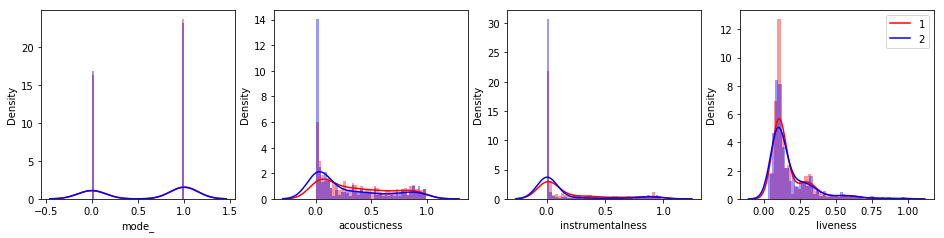

In [17]:
plt.figure(figsize=(16,16))
plt.subplot(4,4,1)
sns.distplot(track_features[track_features['playlist']==0]['mode_'], color='red', bins=40)
sns.distplot(track_features[track_features['playlist']==1]['mode_'], color='blue', bins=40)
plt.subplot(4,4,2)
sns.distplot(track_features[track_features['playlist']==0]['acousticness'], color='red', bins=40)
sns.distplot(track_features[track_features['playlist']==1]['acousticness'], color='blue', bins=40)
plt.subplot(4,4,3)
sns.distplot(track_features[track_features['playlist']==0]['instrumentalness'], color='red', bins=40)
sns.distplot(track_features[track_features['playlist']==1]['instrumentalness'], color='blue', bins=40)
plt.subplot(4,4,4)
sns.distplot(track_features[track_features['playlist']==0]['liveness'], color='red', bins=40)
sns.distplot(track_features[track_features['playlist']==1]['liveness'], color='blue', bins=40)
plt.legend((1,2));

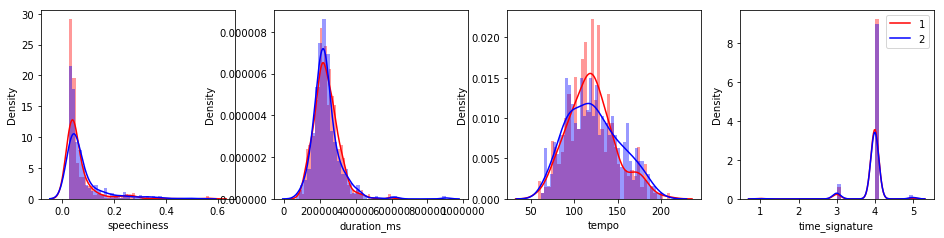

In [18]:
plt.figure(figsize=(16,16))
plt.subplot(4,4,1)
sns.distplot(track_features[track_features['playlist']==0]['speechiness'], color='red', bins=40)
sns.distplot(track_features[track_features['playlist']==1]['speechiness'], color='blue', bins=40)
plt.subplot(4,4,2)
sns.distplot(track_features[track_features['playlist']==0]['duration_ms'], color='red', bins=40)
sns.distplot(track_features[track_features['playlist']==1]['duration_ms'], color='blue', bins=40)
plt.subplot(4,4,3)
sns.distplot(track_features[track_features['playlist']==0]['tempo'], color='red', bins=40)
sns.distplot(track_features[track_features['playlist']==1]['tempo'], color='blue', bins=40)
plt.subplot(4,4,4)
sns.distplot(track_features[track_features['playlist']==0]['time_signature'], color='red', bins=40)
sns.distplot(track_features[track_features['playlist']==1]['time_signature'], color='blue', bins=40)
plt.legend((1,2));

In [19]:
y = track_features['playlist']
X = track_features.drop('playlist', axis=1)

In [20]:
y.sample(10)

255    0
655    1
267    0
672    1
153    0
310    0
427    1
191    0
679    1
166    0
Name: playlist, dtype: int64

In [21]:
X.head()

,danceability,energy,key,loudness,mode_,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,time_signature
0,0.319,0.236,5,-9.644,1,0.0318,0.8980,0.000016,0.2720,162.351,156091,4
1,0.806,0.398,2,-8.211,1,0.3540,0.7450,0.000000,0.0906,95.146,141932,4
2,0.637,0.519,6,-9.461,1,0.0283,0.3430,0.000057,0.2730,145.024,268147,4
3,0.797,0.755,2,-5.393,1,0.0293,0.3310,0.000002,0.1240,129.955,135878,4
4,0.619,0.481,10,-7.850,0,0.0366,0.0131,0.000100,0.1010,133.977,238067,4


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [23]:
print("Proportion of positive class in training set:", y_train.sum() / y_train.shape[0])
print("Proportion of positive class in test set:", y_test.sum() / y_test.shape[0])

Proportion of positive class in training set: 0.5
Proportion of positive class in test set: 0.5


### Baseline evaluation using linear regression model

In [83]:
lr_model = LogisticRegression(C=1, penalty="l1", solver="liblinear").fit(X_train, y_train)

In [84]:
lr_pred = lr_model.predict(X_test)
print(confusion_matrix(y_test, lr_pred))
print('\n') # space
print(classification_report(y_test, lr_pred))

[[75 46]
 [47 74]]


              precision    recall  f1-score   support

           0       0.61      0.62      0.62       121
           1       0.62      0.61      0.61       121

    accuracy                           0.62       242
   macro avg       0.62      0.62      0.62       242
weighted avg       0.62      0.62      0.62       242



In [86]:
print(lr_pred.sum())
print(lr_pred.shape)


120
(242,)


In [159]:
x_train_array = X_train.values
x_test_array = X_test.values
y_train_array = y_train.values
y_test_array = y_test.values

In [160]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [161]:
scaled_x_train_array = NormalizeData(x_train_array)
scaled_x_test_array = NormalizeData(x_test_array)
print(scaled_x_test_array)

[[2.87477844e-05 2.87666006e-05 4.02012967e-05 ... 1.55363994e-04
  2.14763671e-01 3.24534627e-05]
 [2.87367161e-05 2.87212204e-05 2.80261290e-05 ... 1.68109180e-04
  2.42040474e-01 3.24534627e-05]
 [2.86625582e-05 2.82043292e-05 3.35602961e-05 ... 1.04405383e-04
  2.31072862e-01 3.24534627e-05]
 ...
 [2.86371011e-05 2.85806526e-05 3.02397959e-05 ... 1.10871504e-04
  3.95123284e-01 3.24534627e-05]
 [2.88341174e-05 2.89868604e-05 3.35602961e-05 ... 1.92077658e-04
  3.87862457e-01 3.24534627e-05]
 [2.87234341e-05 2.88673224e-05 3.24534627e-05 ... 1.42824678e-04
  2.28552602e-01 3.24534627e-05]]


In [162]:
x_train_tensor = torch.from_numpy(scaled_x_train_array)
x_test_tensor = torch.from_numpy(scaled_x_test_array)
y_train_tensor = torch.from_numpy(y_train_array)
y_test_tensor = torch.from_numpy(y_test_array)

In [163]:
device = torch.device("cuda:3") if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda:3 device


In [164]:
class make_dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

    def __len__(self):
        return self.x.shape[0]

train_dataset = make_dataset(scaled_x_train_array, y_train_array)
test_dataset = make_dataset(scaled_x_test_array, y_test_array)

In [165]:
BATCH_SIZE = 50

train_dataloader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=BATCH_SIZE)

train_batch_count = len(train_dataloader.dataset) // BATCH_SIZE
test_batch_count = len(test_dataloader.dataset) // BATCH_SIZE

# The model

In [166]:
class DffNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(DffNetwork,self).__init__()
        self.l1 = nn.Linear(input_size, 36)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(36, 36)
        self.sigmoid1 = nn.Sigmoid()
        self.l3 = nn.Linear(36, output_size)
        self.sigmoid2 = nn.Sigmoid()

    def forward(self, x):
        x = self.l1(x) 
        x = self.relu1(x)
        x = self.l2(x)
        x = self.sigmoid1(x)
        x = self.l3(x) 
        x = self.sigmoid2(x)
        return x

# Training

In [167]:
def train_model(
    name, 
    device,
    input_size,
    output_size,
    dataloader,
    model=DffNetwork, 
    optimizer=torch.optim.Adam, 
    loss_fn=nn.BCELoss, 
    learning_rate=0.001, 
    n_epochs=30
):
    this_model = model(input_size, output_size)
    this_model.to(device)

    loss_fn = loss_fn()
    opt = optimizer(this_model.parameters(), lr=learning_rate)
    history = {"train_loss": []}

    for e in range(0, n_epochs):
        this_model.train()

        train_loss = 0

        for (x, y) in dataloader:
            (x, y) = (x.to(device), y.float().to(device))

            pred = this_model(x)
            loss = loss_fn(pred, y.unsqueeze(1))

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss

        avg_train_loss = train_loss / train_batch_count
        history["train_loss"].append(float(avg_train_loss.cpu().detach().numpy()))

        print(f"[INFO] EPOCH: {e + 1}/{n_epochs}")
        print(f"Average train loss: {float(avg_train_loss.detach().cpu().numpy())}")
    param_save_path = f"./parameters_{name}_{optimizer.__name__}_{learning_rate}_{n_epochs}.pth"
    history_save_path = f"./history_{name}_{optimizer.__name__}_{learning_rate}_{n_epochs}.pic"
    torch.save(this_model, param_save_path)
    pickle.dump(history, open(history_save_path, "wb"))
    
    print(f"Parameters saved to path: {param_save_path}")
    print(f"History saved to path: {history_save_path}")

In [179]:
train_model(
    name="DffNetwork",
    model=DffNetwork,
    dataloader=train_dataloader,
    input_size=12,
    output_size=1,
    device=device,
    n_epochs=350,
)

[INFO] EPOCH: 1/350
Average train loss: 0.7817876935005188
[INFO] EPOCH: 2/350
Average train loss: 0.7733636498451233
[INFO] EPOCH: 3/350
Average train loss: 0.7710442543029785
[INFO] EPOCH: 4/350
Average train loss: 0.7701936364173889
[INFO] EPOCH: 5/350
Average train loss: 0.7704346776008606
[INFO] EPOCH: 6/350
Average train loss: 0.770297646522522
[INFO] EPOCH: 7/350
Average train loss: 0.7703502774238586
[INFO] EPOCH: 8/350
Average train loss: 0.770234227180481
[INFO] EPOCH: 9/350
Average train loss: 0.7708046436309814
[INFO] EPOCH: 10/350
Average train loss: 0.7703247666358948
[INFO] EPOCH: 11/350
Average train loss: 0.7702637910842896
[INFO] EPOCH: 12/350
Average train loss: 0.7703706622123718
[INFO] EPOCH: 13/350
Average train loss: 0.7703659534454346
[INFO] EPOCH: 14/350
Average train loss: 0.7702704071998596
[INFO] EPOCH: 15/350
Average train loss: 0.7707966566085815
[INFO] EPOCH: 16/350
Average train loss: 0.7701495289802551
[INFO] EPOCH: 17/350
Average train loss: 0.77072376

[INFO] EPOCH: 146/350
Average train loss: 0.7698029279708862
[INFO] EPOCH: 147/350
Average train loss: 0.7696523666381836
[INFO] EPOCH: 148/350
Average train loss: 0.7697128653526306
[INFO] EPOCH: 149/350
Average train loss: 0.7696607112884521
[INFO] EPOCH: 150/350
Average train loss: 0.7696598768234253
[INFO] EPOCH: 151/350
Average train loss: 0.769608199596405
[INFO] EPOCH: 152/350
Average train loss: 0.7699514627456665
[INFO] EPOCH: 153/350
Average train loss: 0.7696165442466736
[INFO] EPOCH: 154/350
Average train loss: 0.7699410915374756
[INFO] EPOCH: 155/350
Average train loss: 0.7697065472602844
[INFO] EPOCH: 156/350
Average train loss: 0.770018458366394
[INFO] EPOCH: 157/350
Average train loss: 0.7698225378990173
[INFO] EPOCH: 158/350
Average train loss: 0.7696251273155212
[INFO] EPOCH: 159/350
Average train loss: 0.7699128985404968
[INFO] EPOCH: 160/350
Average train loss: 0.7698673605918884
[INFO] EPOCH: 161/350
Average train loss: 0.7694965600967407
[INFO] EPOCH: 162/350
Aver

[INFO] EPOCH: 285/350
Average train loss: 0.7684011459350586
[INFO] EPOCH: 286/350
Average train loss: 0.7682914137840271
[INFO] EPOCH: 287/350
Average train loss: 0.7681706547737122
[INFO] EPOCH: 288/350
Average train loss: 0.7683313488960266
[INFO] EPOCH: 289/350
Average train loss: 0.7682887315750122
[INFO] EPOCH: 290/350
Average train loss: 0.7687515020370483
[INFO] EPOCH: 291/350
Average train loss: 0.7688391804695129
[INFO] EPOCH: 292/350
Average train loss: 0.7682107090950012
[INFO] EPOCH: 293/350
Average train loss: 0.7679802775382996
[INFO] EPOCH: 294/350
Average train loss: 0.7683899402618408
[INFO] EPOCH: 295/350
Average train loss: 0.7684891223907471
[INFO] EPOCH: 296/350
Average train loss: 0.7681365013122559
[INFO] EPOCH: 297/350
Average train loss: 0.7685491442680359
[INFO] EPOCH: 298/350
Average train loss: 0.7681024670600891
[INFO] EPOCH: 299/350
Average train loss: 0.768312931060791
[INFO] EPOCH: 300/350
Average train loss: 0.7678751349449158
[INFO] EPOCH: 301/350
Ave

# Testing and Evaluation

In [180]:
def get_predictions(raw_preds):
    batch_predictions = []
    for item in raw_preds:
        batch_predictions.append(np.asarray(item.detach().cpu().numpy() > THRESHOLD, int))
    return batch_predictions

def get_evaluation_variables(parameter_file, device="cuda:2"):
    this_model = torch.load(parameter_file).to(device)
    
    with torch.no_grad():
        this_model.eval()
        
        test_preds = []
        test_truth = []
        raw_preds = []
        
        loss_fn = nn.BCELoss()
        test_loss = 0
        
        for (x, y) in test_dataloader:
            (x, y) = (x.to(device), y.to(device))
            
            batch_preds = this_model(x)
            test_loss += loss_fn(batch_preds, y.unsqueeze(1))
            
            raw_preds.extend(np.asarray(batch_preds.detach().cpu().numpy()))
            test_preds.extend(get_predictions(batch_preds))
            test_truth.extend(y.detach().cpu())
            
        avg_test_loss = test_loss / test_batch_count
        test_preds = test_preds 
        test_truth = test_truth
        raw_preds = raw_preds
    
    return test_preds, test_truth, avg_test_loss, raw_preds

def get_evaluation_metrics(preds, ground_truth, avg_test_loss, device="cpu"):
    prediction_tensor = torch.Tensor(preds).to(device)
    ground_truth_tensor = torch.Tensor(ground_truth).to(device)
    confusion_vector = prediction_tensor / ground_truth_tensor

    tp = torch.sum(confusion_vector == 1).item()
    fp = torch.sum(confusion_vector == float('inf')).item()
    tn = torch.sum(torch.isnan(confusion_vector)).item()
    fn = torch.sum(confusion_vector == 0).item()

    accuracy = (tp + tn) / (tp + fp + tn + fn)
    recall = tp / (tp + fn)

    try:
        precision = tp / (tp + fp)
    except ZeroDivisionError:
        precision = 0

    try:
        f1_score = 2 * ((precision * recall) / (precision + recall))
    except ZeroDivisionError:
        f1_score = 0

    return pd.DataFrame({
        "Average Test Loss": avg_test_loss.item(),
        "Accuracy": accuracy,
        "Recall": recall,
        "Precision": precision,
        "F1-Score": f1_score,
    }, index=["Test Metrics"]).round(4)

def display_training_validation_loss(history_file):
    history = pd.DataFrame(pickle.load(open(history_file, "rb")))
    history["Epoch"] = [e for e in range(1, len(history) + 1)]
    history = history.rename(columns={"train_loss": "Train Loss"})

    plt.plot("Epoch", "Train Loss", data=history, marker='', color='skyblue', linewidth=2)

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [186]:
THRESHOLD = 0.5368330127690449

preds, ground_truth, avg_test_loss, raw_preds = get_evaluation_variables(
    parameter_file="./parameters_DffNetwork_Adam_0.001_350.pth", 
)

In [182]:
list_raw_preds = [arr.tolist() for arr in raw_preds]

In [183]:
flat_raw_preds = [item for sublist in list_raw_preds for item in sublist]

In [184]:
highest_pred = max(flat_raw_preds)
lowest_pred = min(flat_raw_preds)

print(f'Highest value: {highest_pred}\nLowest value: {lowest_pred}')

Highest value: 0.5774432420730591
Lowest value: 0.4677903950214386


In [185]:
median_threshold = (highest_pred + lowest_pred)/2
median_threshold

0.5226168185472488

In [175]:
mean_thresh = sum(flat_raw_preds)/len(flat_raw_preds)
mean_thresh

0.5368330127690449

In [187]:
get_evaluation_metrics(preds, ground_truth, avg_test_loss)

,Average Test Loss,Accuracy,Recall,Precision,F1-Score
Test Metrics,0.8675,0.5,0.0413,0.5,0.0763


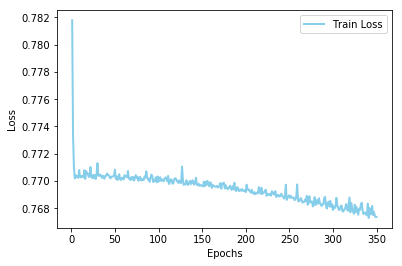

In [188]:
display_training_validation_loss(history_file="history_DffNetwork_Adam_0.001_350.pic")